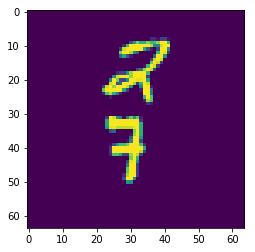

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
import os.path
import numpy as np
import sys
sys.path.insert(0, './')
from utils import plot_mats
from pgpnn import ImageSplitter, PredictiveGatingPyramid

file_name = 'mnist_test_seq.npy'
url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

if not os.path.isfile(file_name):
    print("could not find dataset: download it..")
    urllib.request.urlretrieve(url, file_name)
    print("download complete")

# Moving Mnist: 10.000 sequences of length 20 showing 2 digits moving in 64x64
moving_mnist = np.load(file_name) # shape: 20,10000,64,64
moving_mnist = np.rollaxis(moving_mnist, 1) # --> 10000,20,64,64

plt.imshow(moving_mnist[0,0])
plt.show()

[CONSTRUCT LAYER 1]
	could not preload weights for Layer 1
[CONSTRUCT LAYER 2]
	could not preload weights for Layer 2
Training: Epoch: 001/1000 cost: 988.476562500 time: 23.90
Training: Epoch: 002/1000 cost: 928.349896599 time: 22.55
Training: Epoch: 003/1000 cost: 908.960190717 time: 22.56
Training: Epoch: 004/1000 cost: 903.059570312 time: 22.51
Training: Epoch: 005/1000 cost: 899.812614890 time: 22.71
Training: Epoch: 006/1000 cost: 897.397116268 time: 22.54
Training: Epoch: 007/1000 cost: 895.465647978 time: 22.32
Training: Epoch: 008/1000 cost: 893.902745864 time: 22.45
Training: Epoch: 009/1000 cost: 892.428021599 time: 22.60
Training: Epoch: 010/1000 cost: 891.368278952 time: 22.42
Training: Epoch: 011/1000 cost: 890.455078125 time: 22.34
Training: Epoch: 012/1000 cost: 889.753963695 time: 22.49
Training: Epoch: 013/1000 cost: 888.894703585 time: 22.71
Training: Epoch: 014/1000 cost: 888.401941636 time: 22.63
Training: Epoch: 015/1000 cost: 887.914522059 time: 22.48
Training: Ep

Training: Epoch: 141/1000 cost: 794.968232996 time: 22.70
Training: Epoch: 142/1000 cost: 793.831054688 time: 22.51
Training: Epoch: 143/1000 cost: 793.574161305 time: 22.51
Training: Epoch: 144/1000 cost: 793.674517463 time: 22.51
Training: Epoch: 145/1000 cost: 794.038430607 time: 22.77
Training: Epoch: 146/1000 cost: 792.866555607 time: 22.56
Training: Epoch: 147/1000 cost: 792.642578125 time: 22.51
Training: Epoch: 148/1000 cost: 792.807215074 time: 22.52
Training: Epoch: 149/1000 cost: 793.118681066 time: 22.63
Training: Epoch: 150/1000 cost: 791.904239430 time: 22.44
Training: Epoch: 151/1000 cost: 791.721449908 time: 22.55
Training: Epoch: 152/1000 cost: 791.879078585 time: 22.55
Training: Epoch: 153/1000 cost: 792.201344210 time: 22.73
Training: Epoch: 154/1000 cost: 790.950367647 time: 22.54
Training: Epoch: 155/1000 cost: 790.802849265 time: 22.44
Training: Epoch: 156/1000 cost: 790.936006434 time: 22.42
Training: Epoch: 157/1000 cost: 791.297621783 time: 22.66
Training: Epoc

Training: Epoch: 283/1000 cost: 750.775562960 time: 22.53
Training: Epoch: 284/1000 cost: 750.496897978 time: 22.45
Training: Epoch: 285/1000 cost: 752.341337316 time: 22.70
Training: Epoch: 286/1000 cost: 751.322380515 time: 22.62
Training: Epoch: 287/1000 cost: 750.205939798 time: 22.56
Training: Epoch: 288/1000 cost: 749.941291360 time: 22.59
Training: Epoch: 289/1000 cost: 751.740349265 time: 22.63
Training: Epoch: 290/1000 cost: 750.726849724 time: 22.60
Training: Epoch: 291/1000 cost: 749.667566636 time: 22.49
Training: Epoch: 292/1000 cost: 749.434340533 time: 22.54
Training: Epoch: 293/1000 cost: 751.117589614 time: 22.56
Training: Epoch: 294/1000 cost: 750.118853401 time: 22.54
Training: Epoch: 295/1000 cost: 749.165268842 time: 22.50
Training: Epoch: 296/1000 cost: 748.936178768 time: 22.57
Training: Epoch: 297/1000 cost: 750.512752757 time: 22.69
Training: Epoch: 298/1000 cost: 749.528492647 time: 22.44
Training: Epoch: 299/1000 cost: 748.672564338 time: 22.60
Training: Epoc

Training: Epoch: 425/1000 cost: 733.591969210 time: 22.60
Training: Epoch: 426/1000 cost: 733.129365809 time: 22.33
Training: Epoch: 427/1000 cost: 732.646426930 time: 22.51
Training: Epoch: 428/1000 cost: 732.875000000 time: 22.46
Training: Epoch: 429/1000 cost: 732.798943015 time: 22.69
Training: Epoch: 430/1000 cost: 732.310719210 time: 22.50
Training: Epoch: 431/1000 cost: 731.837316176 time: 22.48
Training: Epoch: 432/1000 cost: 732.033260570 time: 22.54
Training: Epoch: 433/1000 cost: 732.068589154 time: 22.61
Training: Epoch: 434/1000 cost: 731.568531710 time: 22.55
Training: Epoch: 435/1000 cost: 731.123448989 time: 22.50
Training: Epoch: 436/1000 cost: 731.288373162 time: 22.50
Training: Epoch: 437/1000 cost: 731.409926471 time: 22.65
Training: Epoch: 438/1000 cost: 730.914005055 time: 22.53
Training: Epoch: 439/1000 cost: 730.508386949 time: 22.49
Training: Epoch: 440/1000 cost: 730.639590993 time: 22.58
Training: Epoch: 441/1000 cost: 730.817727482 time: 22.71
Training: Epoc

Training: Epoch: 567/1000 cost: 717.235926011 time: 22.62
Training: Epoch: 568/1000 cost: 717.598517923 time: 22.56
Training: Epoch: 569/1000 cost: 716.864085478 time: 22.63
Training: Epoch: 570/1000 cost: 716.689682904 time: 22.51
Training: Epoch: 571/1000 cost: 716.877872243 time: 22.52
Training: Epoch: 572/1000 cost: 717.257697610 time: 22.51
Training: Epoch: 573/1000 cost: 716.480181526 time: 22.65
Training: Epoch: 574/1000 cost: 716.341164982 time: 22.54
Training: Epoch: 575/1000 cost: 716.533030790 time: 22.56
Training: Epoch: 576/1000 cost: 716.919289982 time: 22.39
Training: Epoch: 577/1000 cost: 716.102941176 time: 22.75
Training: Epoch: 578/1000 cost: 715.995978860 time: 22.35
Training: Epoch: 579/1000 cost: 716.196806066 time: 22.53
Training: Epoch: 580/1000 cost: 716.581973805 time: 22.55
Training: Epoch: 581/1000 cost: 715.727481618 time: 22.64
Training: Epoch: 582/1000 cost: 715.659122243 time: 22.64
Training: Epoch: 583/1000 cost: 715.871036305 time: 22.43
Training: Epoc

Training: Epoch: 709/1000 cost: 707.546645221 time: 22.46
Training: Epoch: 710/1000 cost: 707.459731158 time: 22.38
Training: Epoch: 711/1000 cost: 707.479434743 time: 22.59
Training: Epoch: 712/1000 cost: 707.460477941 time: 22.54
Training: Epoch: 713/1000 cost: 707.364545037 time: 22.63
Training: Epoch: 714/1000 cost: 707.237591912 time: 22.53
Training: Epoch: 715/1000 cost: 707.290326287 time: 22.53
Training: Epoch: 716/1000 cost: 707.202722886 time: 22.58
Training: Epoch: 717/1000 cost: 707.222139246 time: 22.75
Training: Epoch: 718/1000 cost: 707.031077665 time: 22.59
Training: Epoch: 719/1000 cost: 707.078412224 time: 22.45
Training: Epoch: 720/1000 cost: 706.987304688 time: 22.49
Training: Epoch: 721/1000 cost: 706.967084099 time: 22.75
Training: Epoch: 722/1000 cost: 706.842313879 time: 22.59
Training: Epoch: 723/1000 cost: 706.845243566 time: 22.34
Training: Epoch: 724/1000 cost: 706.794806985 time: 22.47
Training: Epoch: 725/1000 cost: 706.816119026 time: 22.49
Training: Epoc

Training: Epoch: 851/1000 cost: 699.885167739 time: 22.52
Training: Epoch: 852/1000 cost: 699.655618107 time: 22.55
Training: Epoch: 853/1000 cost: 700.179917279 time: 22.63
Training: Epoch: 854/1000 cost: 699.360926011 time: 22.54
Training: Epoch: 855/1000 cost: 699.633674173 time: 22.51
Training: Epoch: 856/1000 cost: 699.442210478 time: 22.46
Training: Epoch: 857/1000 cost: 699.980526195 time: 22.62
Training: Epoch: 858/1000 cost: 699.113740809 time: 22.44
Training: Epoch: 859/1000 cost: 699.396024816 time: 22.50
Training: Epoch: 860/1000 cost: 699.196231618 time: 22.47
Training: Epoch: 861/1000 cost: 699.776999081 time: 22.65
Training: Epoch: 862/1000 cost: 698.862074908 time: 22.49
Training: Epoch: 863/1000 cost: 699.152113971 time: 22.50
Training: Epoch: 864/1000 cost: 698.956858915 time: 22.52
Training: Epoch: 865/1000 cost: 699.551470588 time: 22.42
Training: Epoch: 866/1000 cost: 698.596047794 time: 22.52
Training: Epoch: 867/1000 cost: 698.920668658 time: 22.47
Training: Epoc

Training: Epoch: 993/1000 cost: 693.102539062 time: 22.65
Training: Epoch: 994/1000 cost: 692.232019761 time: 22.51
Training: Epoch: 995/1000 cost: 692.511029412 time: 22.45
Training: Epoch: 996/1000 cost: 692.335305607 time: 22.44
Training: Epoch: 997/1000 cost: 693.024988511 time: 22.58
Training: Epoch: 998/1000 cost: 691.862936581 time: 22.47
Training: Epoch: 999/1000 cost: 692.285500919 time: 22.44
Training: Epoch: 1000/1000 cost: 692.038315717 time: 22.41


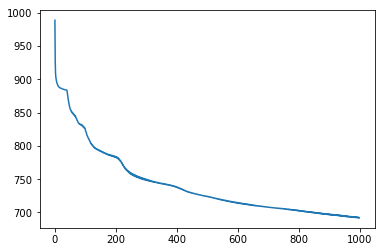

In [2]:
model = PredictiveGatingPyramid(depth=2, modelname='test_pgp_norm')
history = model.train(
    moving_mnist,
    epochs=1000,
    learningRate=0.0001,
    save_results=True,
    load_stages=True)

plt.plot(range(0, len(history)), history)
plt.show()

In [3]:
a = moving_mnist[0,0]
b = moving_mnist[0,1]
c = moving_mnist[0,2]
im = model.predict(a,b,c)

_x (2, 4, 4096)
[CONSTRUCT LAYER 1]
	pre-loading weights for Layer 1
[CONSTRUCT LAYER 2]
	pre-loading weights for Layer 2


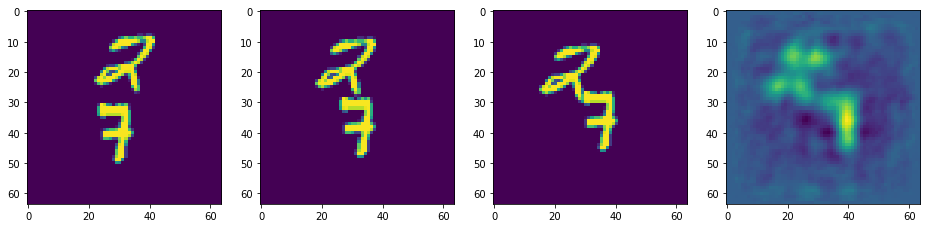

In [4]:
fig = plt.figure(figsize=(16,4))
fig.add_subplot(141).imshow(a)
fig.add_subplot(142).imshow(b)
fig.add_subplot(143).imshow(c)
fig.add_subplot(144).imshow(im)

In [5]:
# print(model.V1_np.shape)
# print(model.U1_np.shape)

# import matplotlib.pyplot as plt
# import pylab

# # function copied from the original code
# def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
#     from pylab import cm, ceil
#     numimages = M.shape[1]
#     if layout is None:
#         n0 = int(np.ceil(np.sqrt(numimages)))
#         n1 = int(np.ceil(np.sqrt(numimages)))
#     else:
#         n0, n1 = layout
#     im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
#     for i in range(n0):
#         for j in range(n1):
#             if i*n1+j < M.shape[1]:
#                 im[i*(height+border)+border:(i+1)*(height+border)+border,
#                    j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
#                             np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
#                                    bordercolor*np.ones((height,border),dtype=float))),
#                             bordercolor*np.ones((border,width+border),dtype=float)
#                             ))
    
#     return im


# I = dispims(model.U1_np, 64, 64, 10)
# J = dispims(model.V1_np, 64, 64, 10)

# fig = plt.figure(figsize=(16,8))
# fig.add_subplot(121).imshow(I)
# fig.add_subplot(122).imshow(J)

# plt.show()